# AER Cleaning

This notebook walks through how the AER articles were sorted into categories of articles and non-articles.

## Load Libraries

In [1]:
from tokenize import Ignore
from numpy import NaN
import pandas as pd
import time
from os import path
import sys
from pathlib import Path
from PyPDF2 import PdfFileReader, PdfFileWriter
import re
import os
from difflib import SequenceMatcher
import datetime
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows',100)
pd.set_option('display.max_colwidth', 120)

## Load Files

Replace the file paths below to match local file paths

In [2]:
base_path="/Users/sijiawu/Work/Thesis/Data"

In [27]:
masters = pd.read_excel(base_path+"/Masterlists/AER_Masterlist.xlsx")
masters10 = pd.read_excel(base_path+ "/2010/AER_master.xlsx")
pivots = pd.read_excel(base_path+"/Pivots/AER_Pivots2020.xlsx")
scopus = pd.read_excel(base_path+"/SCOPUS/AER_SCOPUS.xlsx")

## Create file names

In [21]:
saveas=base_path+"/Processed/AER_processed.xlsx"

## Some random checks on the masters list

My assumption is that all data without author names must be miscellaneous documents like reports by the committee, forewords, front matters etc.. The goal of this notebook is to check for certain that all the documents without author names are actually miscellaneous documents and then classify them as miscellaneous (MISC). Hence, first we group everything the data by title to see the repetitive general content that can likely be removed.

Note: in both cases I've restricted to output to 20 to for sake of viewing on github - there is no scroll function for output.


In [22]:
temp=masters['title'].str.lower().value_counts()
pd.DataFrame(temp[temp>1]).head(20)

,count
title,
new books,2013
front matter,565
discussion,542
back matter,454
notes,304
periodicals,204
volume information,112
titles of new books,106
"documents, reports, and legislation",89


Some repetitions are due to multiple comments. Now consider this list in absence of author names.

In [23]:
temp2=masters[masters['author'].isna()]['title'].str.lower().value_counts()
pd.DataFrame(temp2).head(20)

,count
title,
new books,2007
front matter,565
back matter,453
notes,301
periodicals,204
volume information,112
titles of new books,106
"documents, reports, and legislation",72
report of the finance committee,63


In [11]:
masters10.loc[6149,'title']

'Why are Prices Sticky?: Discussion'

There is also many reports with unique titles due to the year of the report being included in the title. Discussions are no longer part of the table excluding non-authored articles indicating these may be non-adminstrative documents.

The next block corrects for individual errors that were noted.

In [28]:
#Block for misspelling or renaming of data
masters10.loc[8990,'title']="Back Matter"
masters10.loc[10861,'title']="Back Matter"
masters10.loc[16376,'title']="Foreword"
masters10.loc[25807,'title']="Documents, Reports and Legislation"
masters10.loc[25815,'authors']="Alexander Marx"
masters10.loc[25720,'authors']="Review by: James Bonar"
masters10.loc[6425,'content_type']="Discussion"
masters10.loc[2284,'authors']="Victoria Ivashina and David Scharfstein"
masters10.loc[503,'authors']="Jennifer L. Doleac and Benjamin Hansen"
masters10.loc[22177,'authors']="Review by: W. L. Crum"
masters10.loc[22176,'authors']="Review by: Gardiner C. Means"
masters10.loc[24681,'authors']="Review by: Victor H. Pelz"
masters10.loc[6073,'authors']='Haizhou Huang'
masters10.loc[19384,'authors']='Review by: Anon'
masters10.loc[6149,'content_type']="Discussion"
masters10.loc[18729,'authors']='Anon'
masters10.loc[14710,'authors']='Anon'
masters10.loc[14710,'title']='Human Resources: The Wealth of a Nation by Eli Ginzberg: Erratum'
masters10.loc[24876,'authors']='Review by: Henry Pratt Fairchild'
masters10.loc[11919,'authors']='Review by: Anon'
masters10.loc[23831,'authors']='Review by: Roy G. Blakey'
masters10.loc[24620,'authors']='Review by: Ralph H. Blanchard'
masters10.loc[27402,'authors']='Review by: Anon'
masters10.loc[19927,'authors']='Anon'

masters.loc[11764, 'title']="Discussion"


/var/folders/5b/5mt219qj6l552yrf3l89xgdh0000gn/T/ipykernel_32973/3939795049.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Discussion' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  masters10.loc[6425,'content_type']="Discussion"


In [29]:
masters.columns

Index(['type', 'issue_url', 'ISSN', 'URL', 'journal', 'number', 'publisher',
       'title', 'urldate', 'volume', 'year', 'abstract', 'author', 'pages',
       'reviewed-author', 'uploaded'],
      dtype='object')

## Combine the scraped list with the citations files

I have found that masterlists contructed from citation files lack the reviewed source's name while it is present on the page of the article. Some files are just missing the title. So I'm combining the old masterlists with the new ones.

In [30]:
masters["URL"]="https:"+masters["URL"].str.split(':').str[-1]
masters.drop('type', inplace=True, axis=1)
masters10["stable_url"]="https:"+masters10["stable_url"].str.split(':').str[-1]
masters10.rename(columns = {'authors':'author','stable_url':'URL','title':'title_10'}, inplace = True)
scopus.rename(columns = {'abstract':'abstractSCO', 'title':'titleSCO', 'journal':'journalSCO', 'authors':'authorsSCO','issue':'number'}, inplace = True)
masters['pages']=masters['pages'].str.strip()  
masters.loc[masters.title.str.lower() == "back matter", 'pages'] = NaN  
pivots['type']=NaN
masters['pages']=masters["pages"].str.split('pp. ').str[-1]
masters['pages']=masters['pages'].replace(r'--','-',regex=True).str.strip()

## Format Author Names

there are two sets of data here. The master lists constructed from scraping each page and the masterlists constructed from the bibtex files for each article.

In [31]:
masters["author_split"]=masters['author'].str.split(' and ')


In [32]:
masters=masters.merge(masters10[['URL', 'title_10']], how='left', on='URL')
masters.loc[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False), 'content_type']="Review"


In [33]:
masters.loc[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False),"title"]=masters[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False)]["title_10"]
masters.loc[(pd.isna(masters["title_10"])==False)&(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==True)&(pd.isna(masters["author"])==True),"title"]=masters[(pd.isna(masters["title_10"])==False)&(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==True)&(pd.isna(masters["author"])==True)]["title_10"]

In [34]:
for i in masters[(pd.isna(masters["title_10"])==False)&(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==True)].index:
    temp=masters.iloc[i]
    indic=0
    if len(temp['author_split'])>1:
        for j in temp['author_split']:
            if j in temp["title_10"]:
                indic=1
                masters.loc[i, "title"]=temp["title_10"]
                masters.loc[i, "reviewed-author"]=j
                if "Review by:" in temp["title_10"]:
                    print("weird")
    if indic==0:
        masters.loc[i, 'title']=temp['title_10']

In [35]:
masters.loc[masters['number']==datetime.datetime(2023, 4, 5, 0, 0),"number"]="4-5"
masters.loc[masters['number']==datetime.datetime(2023, 1, 2, 0, 0),"number"]="1-2"


## Classifying Miscellaneous content

In [36]:
masters.loc[masters.title.str.lower() == "back matter", 'content_type'] = "MISC"  
masters.loc[masters.title.str.lower() == "front matter", 'content_type'] = "MISC"
masters.loc[masters.title.str.lower() == "volume matter", 'content_type'] = "MISC"
masters.loc[masters.title == "Announcements", 'content_type'] = "MISC"
masters.loc[masters.title == "Announcement", 'content_type'] = "MISC"
masters.loc[masters.title.str.lower() == "foreword", 'content_type'] = "MISC"
masters.loc[masters.title == "Periodicals", 'content_type'] = "MISC"

masters.loc[masters.title.str.lower() == "doctoral dissertations", 'content_type'] = "MISC"
masters.loc[masters.title == "Editorial Statement", 'content_type'] = "MISC"
masters.loc[masters.title.str.lower() == "list of members", 'content_type'] = "MISC" 
masters.loc[masters.title.str.lower() == "annual meetings", 'content_type'] = "MISC" 
masters.loc[masters.title.str.lower() == "biographical listing of members", 'content_type'] = "MISC" 
masters.loc[masters.title.str.lower() == "honorary members", 'content_type'] = "MISC" 
masters.loc[masters.title.str.lower().str.contains("preliminary announcement of the program"), 'content_type'] = "MISC"
masters.loc[masters["title"].str.contains("Distinguished Fellow"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("\[photograph\]"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("volume information"),'content_type']="MISC"
masters.loc[masters['title'].str.contains("The John Bates Clark Award"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("new books"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("titles of new books"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("new book"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("the american economic association"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("in memoriam"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("in memorium"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("memorial:"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("list of doctoral dissertations"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("notes") & masters['author'].isna(),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("documents, reports and legislation"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("documents, reports, and legislation"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("editor") & masters["title"].str.lower().str.contains("introduction"),'content_type']="MISC"
masters.loc[masters['title'].str.match(r"^Editorial Note")==True, "content_type"]="MISC"
masters.loc[masters['title'].str.match(r"^Editor's Note")==True, "content_type"]="MISC"
masters.loc[masters["title"].str.lower().str.contains("classification of members"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("aer survey of members"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("annual business meeting"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("auditor") & masters["title"].str.lower().str.contains("report"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("proceedings of the") & masters["title"].str.lower().str.contains("annual meeting"),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("report of the") & masters['author'].isna(),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'^report of the treasurer')==True, 'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'^report of the director:')==True, 'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'^report of the managing editor')==True,'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'^report of the editor:')==True,'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'^report of the secretary')==True,'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("minutes of the") & masters['author'].isna(),'content_type']="MISC"
masters.loc[masters["title"].str.lower().str.contains("minutes of business meetings") & masters['author'].isna(),'content_type']="MISC"
masters.loc[masters["title"].str.len()<3,'content_type']='MISC'
masters.loc[masters['title'].str.match(r'^Program.*')==True,'content_type']='MISC'
masters.loc[masters['title'].str.match(r'^Business Meeting.*')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'introductory remarks')==True,'content_type']='MISC'

#masters[masters['title'].str.lower().str.contains("review")]['title']
masters.loc[masters['title'].str.lower().str.match(r'the committee on.*')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^report of.* representative')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^report of.*committee on')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^report of.* finance committee')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'.*francis.*walker.*award')==True,'content_type']='MISC'

masters.loc[masters['title'].str.lower().str.match(r'^\[communication\]$')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^\[introduction\]$')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^introduction$')==True,'content_type']='MISC'

masters.loc[masters['author'].isna() & masters['content_type'].isna(),'content_type']='MISC' 


In [691]:
#masters[masters["title"].str.lower().str.contains('affiliation')][['title','stable_url']]
#masters[masters['title'].str.lower().str.match(r'^report of the secretary')==True]
#masters[masters["title"].str.lower().str.contains("aer survey of members")][['title','stable_url']]

... One last check. Note: I found that after removing most of the miscellaneous content the remainder that did not have author names were not articles.

In [692]:
# print(masters[masters['author'].isna() & masters['content_type'].isna()]['title'].shape[0])
# masters[masters['author'].isna() & masters['content_type'].isna()][['title','URL']].sort_values('title')

In [693]:
# pd.DataFrame(masters[masters['content_type'].isna()]['title'].str.lower().value_counts())
#masters[masters.title.str.lower().str.match(r'.*:.*') & masters.content_type.isna()].head()

In [38]:
pd.set_option('display.max_rows',masters.shape[0])
pd.set_option('display.max_colwidth', 100)
#pd.DataFrame(masters[['title', 'stable_url']][(masters['content_type']!='MISC') &(masters['authors'].str.lower().str.contains("review")==False)]).sort_values('title'


## Separating out other types

In [39]:
#masters.loc[~(masters['authors'].isna()) & masters['authors'].str.lower().str.match(r'.*review by:.*'),'content_type']='Review'
masters.loc[~(masters['author'].isna()) & (masters['reviewed-author'].isna()==False),'content_type']='Review'
masters[masters.content_type=='Review'].shape[0]

6801

In [40]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )comment(|.*)$')==True,'content_type']='Comment'
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )further comment(|.*)$')==True,'content_type']='Comment'
masters[masters['content_type']=='Comment'].shape[0]

858

In [41]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )reply(| to.*)$')==True,'content_type']="Reply"
masters[masters['content_type']=='Reply'].shape[0]

507

In [42]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )discussion$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(^|a )discussion(|.*)$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*:.*(|a )discussion(|s)$')==True,'content_type']='Discussion'
masters.loc[masters.title.str.lower().str.match(r'.*--discussion.*') & masters.content_type.isna(),'content_type']='Discussion'
masters[masters['content_type']=='Discussion'].shape[0]

685

In [43]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True,'content_type']="Rejoinder"
masters[masters['content_type']=='Rejoinder'].shape[0]

52

In [44]:
masters.loc[masters['content_type'].isna(),'content_type']="Article"
masters[masters['content_type']=='Article'].shape[0]

12837

In [701]:
# block for testing regex strings
#masters[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )discussion(|.*)$')==True] #false positive for discussion
#masters[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )comment(|.*)$')==True] comments to specific people
#masters[masters.title.str.lower().str.match(r'^(|a )note.*')]

In [45]:
masters[masters.content_type=='Article'].shape[0] #articles in data set

12837

In [46]:
masters[(masters['content_type']=='Article') & (masters['year']>1939)].shape[0] #all articles after 1940

11469

In [47]:
masters[(masters['content_type']=='Article') & (masters.year>1939) & (masters.year<2011)].shape[0] #articles between 1940 and 2010

9495

## Consider the pivots file

At times, conference papers are structured differently to normal articles. Hence, it may be necessary to distinguish conference papers from common articles. The next code block separates special issues (S) from normal issues (N)

In [48]:
pivots.loc[pivots.Jstor_issue_text.str.lower().str.match(r'(.*)(supplement|proceedings|annual meeting|survey)(.*)'),'type']="S"
pivots.loc[pivots.type.isna(),'type']='N'
pivots[pivots.type=='S'].head()

/var/folders/5b/5mt219qj6l552yrf3l89xgdh0000gn/T/ipykernel_32973/3779509515.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'S' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pivots.loc[pivots.Jstor_issue_text.str.lower().str.match(r'(.*)(supplement|proceedings|annual meeting|survey)(.*)'),'type']="S"


,year,issue_url,Jstor_issue_text,journal,type
42,2017,https://www.jstor.org/stable/10.2307/i40178116,No. 5 PAPERS AND PROCEEDINGS OF THE One Hundred Twenty-Ninth Annual Meeting OF THE AMERICAN ECON...,amereconrevi,S
54,2016,https://www.jstor.org/stable/10.2307/i40158602,No. 5 PAPERS AND PROCEEDINGS OF THE One Hundred Twenty-Eighth Annual Meeting OF THE AMERICAN ECO...,amereconrevi,S
66,2015,https://www.jstor.org/stable/10.2307/i40156735,No. 5 PAPERS AND PROCEEDINGS OF THE One Hundred Twenty-Seventh Annual Meeting OF THE AMERICAN EC...,amereconrevi,S
78,2014,https://www.jstor.org/stable/10.2307/i40112127,No. 5 PAPERS AND PROCEEDINGS OF One Hundred Twenty-Sixth Annual Meeting OF THE AMERICAN ECONOMIC...,amereconrevi,S
87,2013,https://www.jstor.org/stable/10.2307/i23469657,No. 3 PAPERS AND PROCEEDINGS OF THE One Hundred Twenty-Fifth Annual Meeting OF THE AMERICAN ECON...,amereconrevi,S


Merging the pivots with masters

In [49]:
result = pd.merge(masters, pivots[['issue_url','type']], how="left", on=["issue_url", "issue_url"])


## Creating counts of the data

In [50]:
pd.DataFrame(masters['content_type'].value_counts()) # counts by content_type


,count
content_type,
Article,12837
Review,6801
MISC,5825
Comment,858
Discussion,685
Reply,507
Rejoinder,52


In [51]:
pd.DataFrame(masters[masters.year>1939].content_type.value_counts()) # counts after 1940 (inclusive)


,count
content_type,
Article,11469
Review,4338
MISC,3031
Comment,837
Discussion,544
Reply,491
Rejoinder,46


In [52]:
pd.DataFrame(masters[(masters.year>1939) & (masters.year<2011)].content_type.value_counts()) 
# counts between 1940 and 2010 (inclusive)

,count
content_type,
Article,9495
Review,4338
MISC,2750
Comment,790
Discussion,544
Reply,461
Rejoinder,46


In [53]:
result.to_excel(saveas, index=False)


## This section aims to match up Scopus records and Jstor articles
If an article's affiliations, citations or abstracts are recorded on Scopus, I want to exclude them from the set of pdf's that are sent to docParser. Matching up the Scopus data is also useful for comparing the textual accuracy of OCR parsers. I use volume, issue, year and page numbers which are common to both the scopus data and the Jstor metadata to match articles. 

Then I use a sequence comparison between the journal titles of the matched articles to decide if the scopus data has been matched correctly. If the match ratio is below 70%, the title is investigated and if wrong, the scopus data for that matched article is eihter corrected or discarded. If the scopus data is missing all of affiliations, abstract and citations fields then the match is also discarded.

Finally, if the document type of scopus is different to the classification done during the cleaning section, the article is reclassified according to the Scopus document type.

In [55]:
cleaned=pd.read_excel(saveas)
scopus['pages']=scopus['pages'].str.strip()
print(scopus.shape)
cleaned.dtypes

(5810, 14)


issue_url           object
ISSN                object
URL                 object
journal             object
number              object
publisher           object
title               object
urldate             object
volume               int64
year                 int64
abstract            object
author              object
pages               object
reviewed-author     object
uploaded           float64
author_split        object
title_10            object
content_type        object
type                object
dtype: object

In [57]:
Merged=pd.merge(cleaned, scopus, on=['year','number','volume','pages'], how='left')


There are 47 titles that don't match. 

In [58]:
count=0
for m in Merged.index:
    
    if(pd.isna(Merged.iloc[m]['titleSCO'])==False):
        ratio=SequenceMatcher(None, Merged.iloc[m]['title'].lower(), Merged.iloc[m]['titleSCO'].lower()).ratio()
        if((ratio<0.7) & (Merged.iloc[m]['content_type']!='MISC')):
            print(Merged.iloc[m]['year'])
            print(ratio)
            count+=1
            A_ratio=SequenceMatcher(None, Merged.iloc[m]['author'].lower(), Merged.iloc[m]['authorsSCO'].lower()).ratio()
            print(A_ratio)
            print(Merged.iloc[m]['URL'])
            print('vol: '+str(Merged.iloc[m]['volume']))
            print('issue: '+str(Merged.iloc[m]['number']))
            print('pages: '+Merged.iloc[m]['pages'])
            print('jstor: '+Merged.iloc[m]['title'])
            print('scopus: '+Merged.iloc[m]['titleSCO'])
            print('jstor: '+Merged.iloc[m]['author'])
            print('scopus: '+Merged.iloc[m]['authorsSCO'])
            print('scopus index: '+str(scopus[scopus['titleSCO']==Merged.iloc[m]['titleSCO']].index))
            print(m)
            print()
print(count)

2014
0.16666666666666666
0.23809523809523808
https://www.jstor.org/stable/43495358
vol: 104
issue: 12
pages: 3814-3840
jstor: Ambiguity Aversion with Three or More Outcomes
scopus: Hospital choices, hospital prices, and financial incentives to physicians?
jstor: Mark J. Machina
scopus: Ho, K.--a--
Pakes, A.--b-- 
scopus index: Index([4331], dtype='int64')
1278

2014
0.30601092896174864
0.2727272727272727
https://www.jstor.org/stable/43495359
vol: 104
issue: 12
pages: 3841-3884
jstor: Hospital Choices, Hospital Prices, and Financial Incentives to Physicians
scopus: Consumption and debt response to unanticipated income shocks: Evidence from a natural experiment in Singapore?
jstor: Kate Ho and Ariel Pakes
scopus: Agarwal, S., Qian, W.
scopus index: Index([4332], dtype='int64')
1279

2014
0.3522012578616352
0.176
https://www.jstor.org/stable/43495360
vol: 104
issue: 12
pages: 3885-3920
jstor: Is It Whom You Know or What You Know? An Empirical Assessment of the Lobbying Process
scopus: Rep

In [59]:
scopus.at[4331,'pages']='3841-3884'
scopus.at[4335,'pages']='3814-3840'
scopus.at[4340,'pages']='3885-3920'
scopus.at[4333,'pages']='3921-3955'
scopus.at[4337,'pages']='3956-3990'
scopus.at[4334,'pages']='3991-4026'
scopus.at[4330,'pages']='4027-4070'
scopus.at[4338,'pages']='4071-4103'
scopus.at[4328,'pages']='4104-4146'
scopus.at[4329,'pages']='4147-4183'
scopus.at[4336,'pages']='4184-4204'
scopus.at[4332,'pages']='4205-4230'
scopus.at[4339,'pages']='4231-4239'

scopus.at[4045,'titleSCO']="Erratum: Macroeconomic Effects of Financial Shocks"
scopus.at[2925,'titleSCO']="Erratum: When does coordination require centralization?"
scopus.at[2581,'titleSCO']="Erratum: Equilibrium incentives in oligopoly"
scopus.at[2722,'titleSCO']="Erratum: International protection of intellectual property"
scopus.at[2370, 'titleSCO']="Erratum: The savers-spenders theory of fiscal policy"
scopus.at[3178,'titleSCO']="Erratum: Women, wealth, and mobility"

In [60]:
Merged=pd.merge(cleaned, scopus, on=['year', 'number','volume','pages'], how='left')

In [61]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.DataFrame(Merged[Merged['document type'].str.len()>100])


,issue_url,ISSN,URL,journal,number,publisher,title,urldate,volume,year,abstract,author,pages,reviewed-author,uploaded,author_split,title_10,content_type,type,authorsSCO,titleSCO,journalSCO,DOI,affiliations,abstractSCO,citations,document type,index keywords,author keywords
53,https://www.jstor.org/stable/10.2307/e26966330,"00028282, 19447981",https://www.jstor.org/stable/26966335,The American Economic Review,8,American Economic Association,Subsidy Policies and Insurance Demand,2023-09-04 00:00:00,110,2020,"Using data from a two-year pricing experiment, we study the impact of subsidy policies on weathe...",Jing Cai and Alain de Janvry and Elisabeth Sadoulet,2422-2453,NaN,1.0,"['Jing Cai', 'Alain de Janvry', 'Elisabeth Sadoulet']",NaN,Article,N,"Cai, J.--a--\nde Janvry, A.--b--\nSadoulet, E.--c--",Subsidy policies and insurance demand,American Economic Review,10.1257/AER.20190661,"a--University of Maryland, NBER, BREAD, United States\nb--University of California, Berkeley, Un...","Using data from a two-year pricing experiment, we study the impact of subsidy policies on weathe...","Ashraf, Nava, Berry, James, Shapiro, Jesse M.|Can Higher Prices Stimulate Product Use? Evidence ...","A Health Products Experiment in Uganda(2019) Journal of Development Economics, 137, pp. 110-124...",NaN,NaN
1313,https://www.jstor.org/stable/10.2307/i40138653,28282,https://www.jstor.org/stable/43495314,The American Economic Review,10,American Economic Association,Competition and Ideological Diversity: Historical Evidence from US Newspapers,2023-09-04 00:00:00,104,2014,We study the competitive forces which shaped ideological diversity in the US press in the early ...,Matthew Gentzkow and Jesse M. Shapiro and Michael Sinkinson,3073-3114,NaN,1.0,"['Matthew Gentzkow', 'Jesse M. Shapiro', 'Michael Sinkinson']",Competition and Ideological Diversity: Historical Evidence from US Newspapers,Article,N,"Gentzkow, M.--a-- --b--\nShapiro, J.M.--a-- --b--\nSinkinson, M.--c--",Competition and ideological diversity: Historical evidence from US newspapers,American Economic Review,10.1257/aer.104.10.3073,"a--University of Chicago Booth School of Business, 5807 S. Woodlawn Avenue, Chicago, IL 60637, ...",We study the competitive forces which shaped ideological diversity in the US press in the early ...,"Ackerberg, D.A., Rysman, M.|Unobserved Product Differentiation in Discrete-Choice Models: Estima...","1850-1967(2006) The Historical Statistics of the United States, pp. 253-266. edited by Susan B....",NaN,NaN
2809,https://www.jstor.org/stable/10.2307/i29730147,28282,https://www.jstor.org/stable/29730164,The American Economic Review,5,American Economic Association,Contextual Inference in Markets: On the Informational Content of Product Lines,2023-09-04 00:00:00,98,2008,Context can influence decisions. This malleability of choice is usually invoked as evidence that...,Emir Kamenica,2127-2149,NaN,1.0,['Emir Kamenica'],Contextual Inference in Markets: On the Informational Content of Product Lines,Article,N,"Kamenica, E.",Contextual inference in markets: On the informational content of product lines,American Economic Review,10.1257/aer.98.5.2127,"Graduate School of Business, University of Chicago, 5807 South Woodlawn Avenue, Chicago, IL 60637",Context can influence decisions. This malleability of choice is usually invoked as evidence that...,"Anand, B.N., Shachar, R.|Brands as Beacons: A New Source of Loyalty to Multiproduct Firms|(2004)...","When and Why Variety Backfires(2005) Marketing Science, 24 (3), pp. 382-395. Gul, F., Pesendorf...",NaN,NaN
4843,https://www.jstor.org/stable/10.2307/i300823,28282,https://www.jstor.org/stable/117017,The American Economic Review,4,American Economic Association,Changes in U.S. Tariffs: The Role of Import Prices and Commercial Policies,2023-09-04 00:00:00,88,1998,NaN,Douglas A. Irwin,1015-1026,NaN,1.0,['Douglas A. Irwin'],Changes in U.S. Tariffs: The Role of Import Prices and Commercial Policies,Article,N,"Irwin, D.A.",Changes in U.S. Tar

In [62]:
Merged.loc[Merged['document type'].str.len()>100,'document type']='Article'


In [64]:
Merged.to_excel(base_path+'/Combined/AER_M_sco_du.xlsx', index=False)

## Scopus Coverage
Some plots to visualize scopus coverage for references and affiliations.

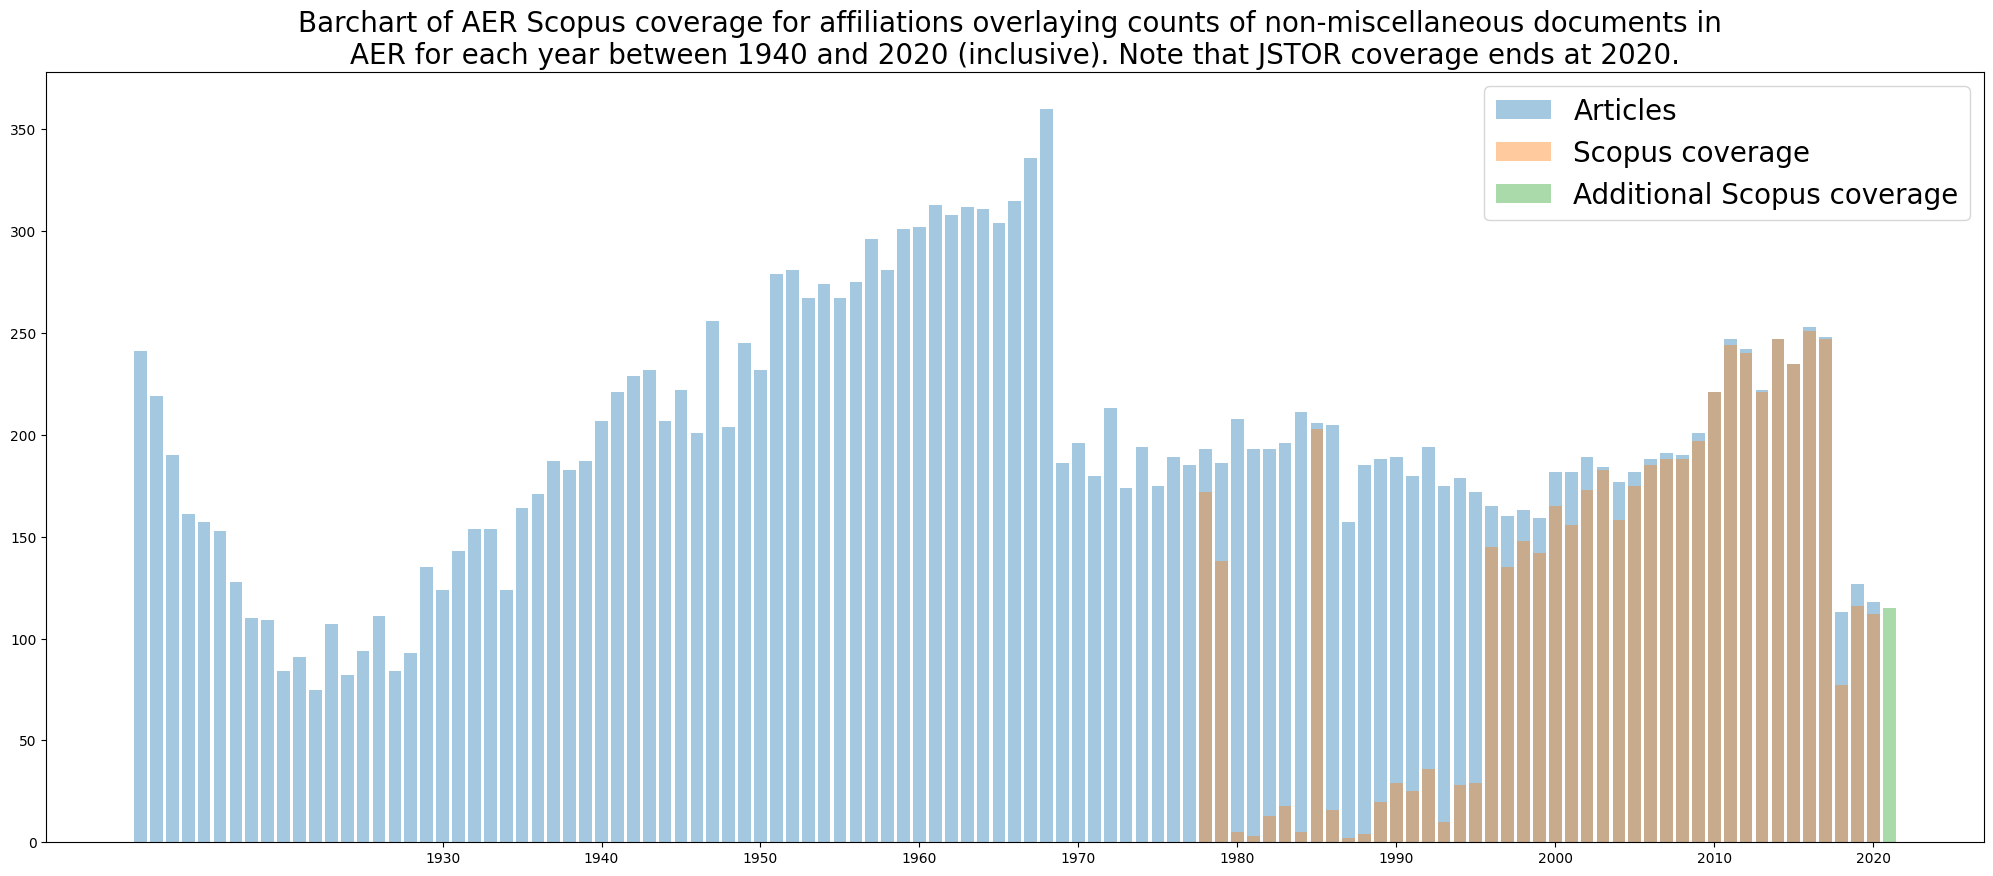

In [70]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta.index,dta, label='Articles', alpha=0.4)
dta2=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
dta3=scopus[(scopus['affiliations'].isnull()==False) & (scopus['year']>2020)]['year'].value_counts()
plt.bar(dta2.index, dta2, label='Scopus coverage', alpha=0.4)
plt.bar(dta3.index, dta3, label='Additional Scopus coverage', alpha=0.4)
plt.title('Barchart of AER Scopus coverage for affiliations overlaying counts of non-miscellaneous documents in \nAER for each year between 1940 and 2020 (inclusive). Note that JSTOR coverage ends at 2020.', fontsize=20)
plt.xticks(np.arange(1930, 2030, 10))
plt.legend(prop={'size': 20})
plt.savefig(base_path+'/figures/aer_affil_sco_coverage.png')

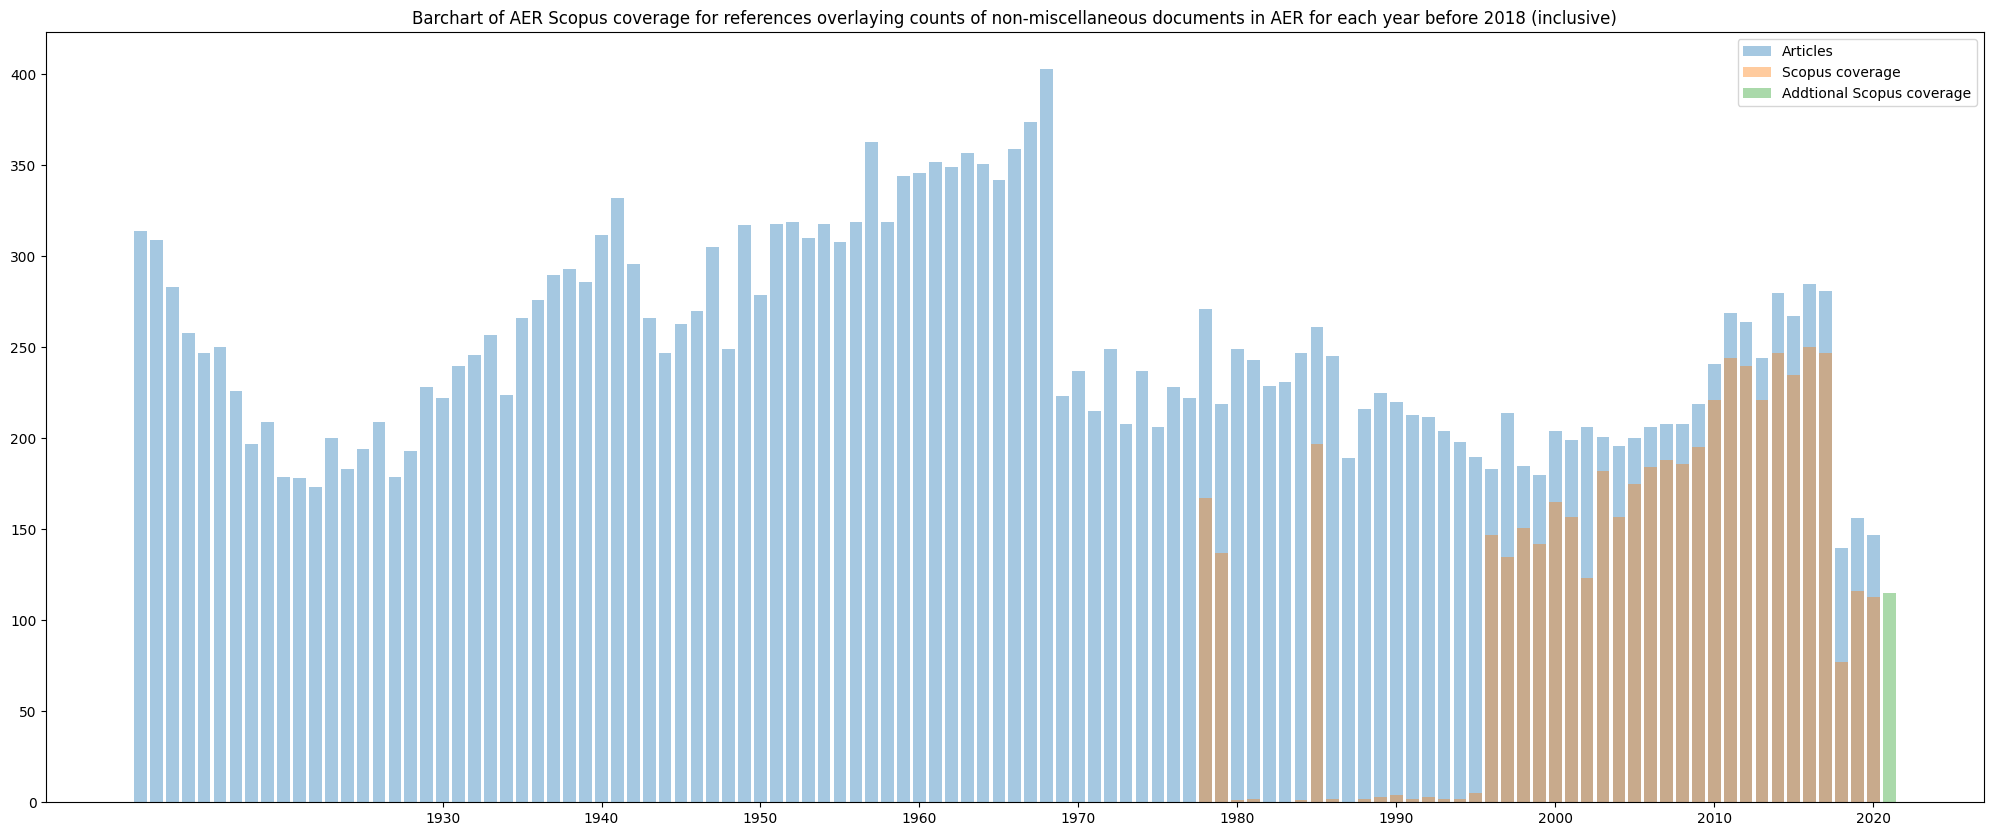

In [71]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged['year'].value_counts()
dta.index
plt.bar(dta.index, dta, alpha=0.4, label='Articles')

dta4=Merged[(Merged['citations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta4.index, dta4, alpha=0.4, label='Scopus coverage')
dta5=scopus[(scopus['citations'].isnull()==False) & (scopus['year']>2020)]['year'].value_counts()
plt.bar(dta5.index, dta5, alpha=0.4, label='Addtional Scopus coverage')
plt.title('Barchart of AER Scopus coverage for references overlaying counts of non-miscellaneous documents in AER for each year before 2018 (inclusive)')
plt.xticks(np.arange(1930, 2030, 10))
plt.legend()

plt.savefig(base_path+'/figures/aer_refs_sco_coverage.png')